In [1]:
import skimage.io as skio
from skimage import exposure
from skimage.util import img_as_ubyte

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import multivariate_normal

%matplotlib inline

Bilder einlesen

In [2]:
Folder='../FE-ImageData/'
IKORed=skio.imread(Folder+'po_221141_red_sub.TIF')
IKOGreen=skio.imread(Folder+'po_221141_green_sub.TIF')
IKOBlue=skio.imread(Folder+'po_221141_blue_sub.TIF')
print(IKORed.shape, IKORed.dtype, np.max(IKORed))
print(30*'=')
print(IKORed[100:110,235:245])


(1764, 1874) uint16 2047
[[502 536 528 530 491 509 550 540 498 526]
 [515 524 509 496 485 527 539 510 525 541]
 [501 510 497 509 517 524 507 515 551 524]
 [498 507 507 523 535 493 501 521 504 535]
 [479 499 534 541 506 506 513 492 516 588]
 [490 523 550 518 502 505 497 520 570 566]
 [523 546 505 503 532 500 536 591 580 575]
 [547 522 503 536 530 526 583 593 562 562]
 [506 504 533 540 473 548 565 570 580 573]
 [500 527 554 490 498 557 566 578 571 563]]


Kanaele zu einem Stack zusammenbauen

In [3]:
IKORGB=np.dstack((IKORed,IKOGreen,IKOBlue))

erstes Subset vom stack nehmen

In [4]:
SubRGB=IKORGB[1000:1200,250:750,:]

Trainingsdaten und Testdaten erstellen

In [5]:
SubRGBWoodTrain=SubRGB[0:50,250:350,:]
SubRGBAgriTrain=SubRGB[125:175,100:200,:]
SubRGBTest=SubRGB[120:170,235:285,:]

Daten darstellen in einem Plot

In [6]:
print(SubRGBTest[0:10,0:10,0])

[[541 530 545 547 539 558 562 572 550 540]
 [539 522 531 522 521 538 557 563 552 555]
 [545 533 534 531 525 530 552 555 556 564]
 [550 533 541 519 527 541 541 517 544 525]
 [545 547 521 522 521 529 527 487 527 497]
 [528 548 532 519 512 506 508 530 550 530]
 [524 542 525 528 503 506 537 549 545 537]
 [513 514 533 537 538 562 550 540 537 545]
 [575 544 563 577 566 562 542 536 540 540]
 [558 555 561 556 554 563 554 552 551 544]]


In [7]:
print(SubRGBWoodTrain.dtype, SubRGBWoodTrain.shape) 

uint16 (50, 100, 3)


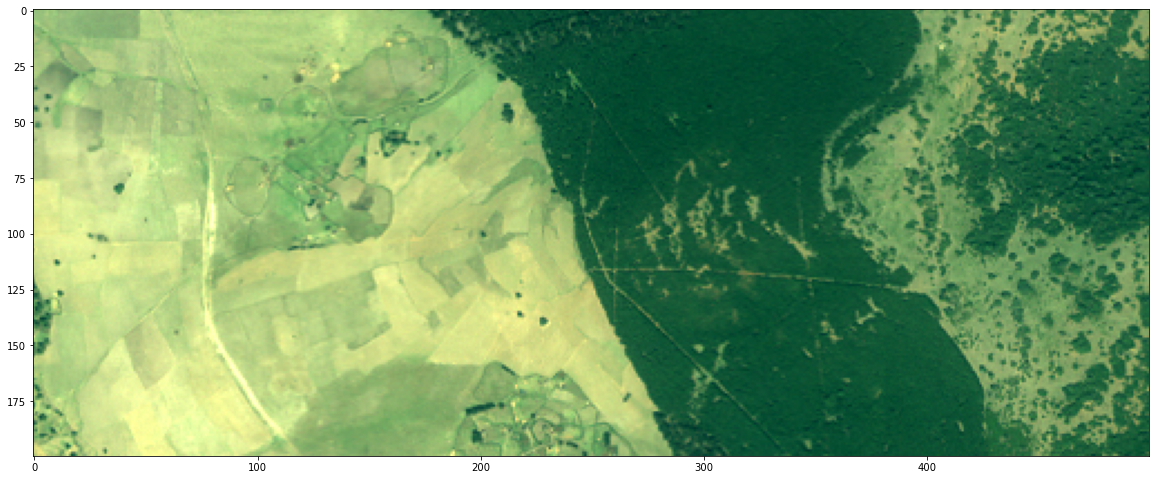

In [8]:
p2, p98 = np.percentile(IKORGB, (2, 98)) 
img_rescale = exposure.rescale_intensity(IKORGB, in_range=(p2, p98))
plt.figure(figsize=(20,20))
plt.imshow(img_as_ubyte(img_rescale[1000:1200,250:750,:]))

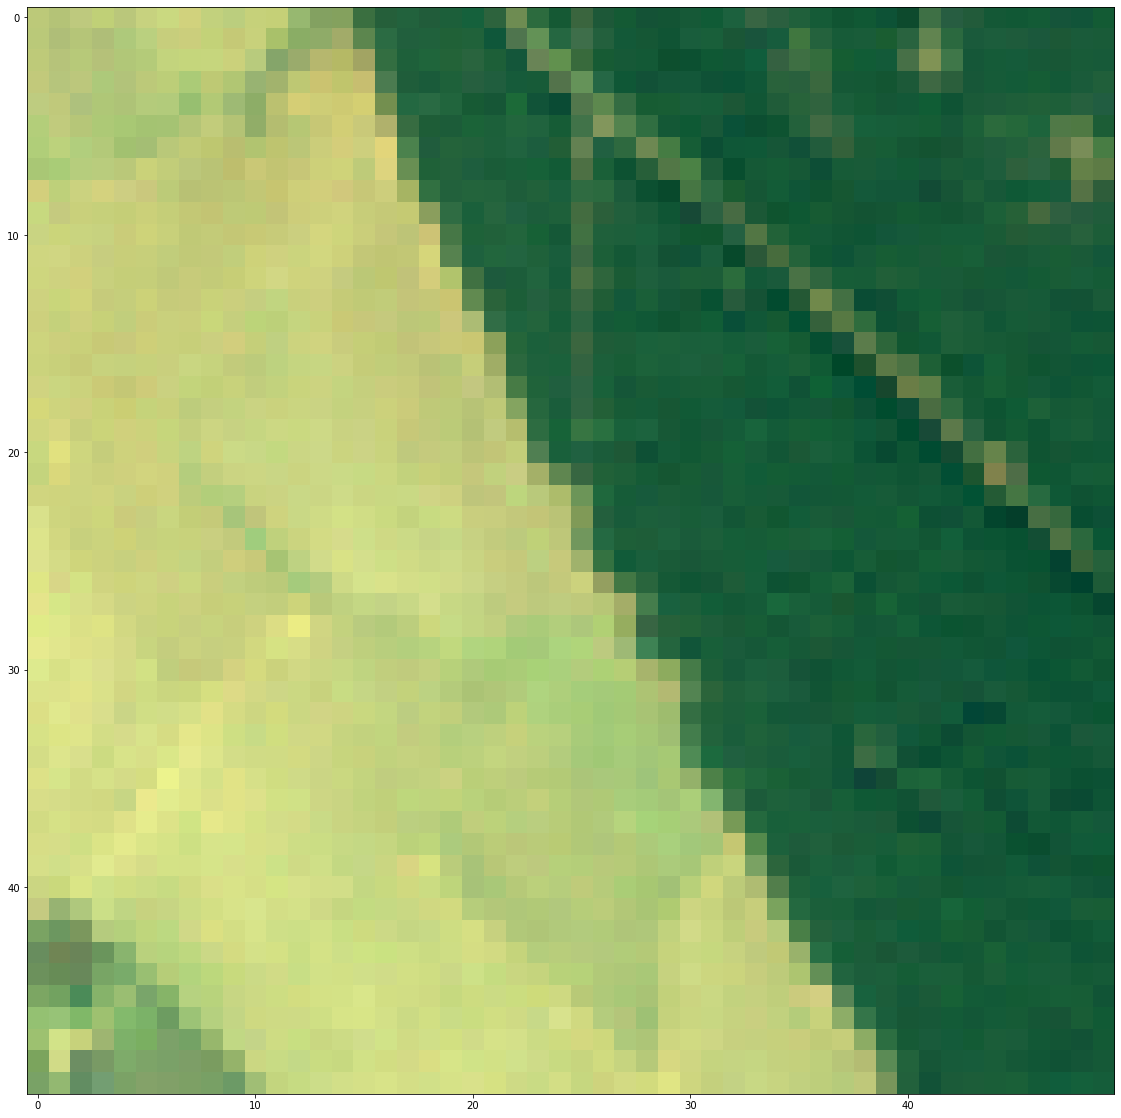

In [9]:
img_rescale = exposure.rescale_intensity(SubRGBTest, in_range=(p2, p98))
plt.figure(figsize=(20,20))
plt.imshow(img_as_ubyte(img_rescale))

plot der Werte in den Pixeln Rot - Horizontale Achse & Grün - Vertikale Achse

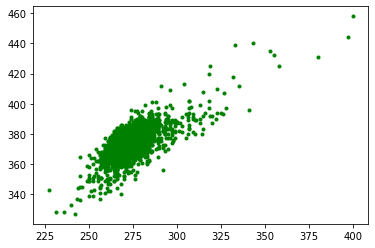

In [10]:
plt.plot(SubRGBWoodTrain[:,:,0].ravel(),SubRGBWoodTrain[:,:,1].ravel(),'g.')

Daten vorbereiten fuer die Klassifikation - Normalverteilungen schaetzen

Waldgebiet

In [11]:
W_MeanRed  = np.mean(SubRGBWoodTrain[:,:,0]) 
W_MeanGreen= np.mean(SubRGBWoodTrain[:,:,1])
W_CovRG    = np.cov(SubRGBWoodTrain[:,:,0].ravel(),SubRGBWoodTrain[:,:,1].ravel())

Ackerland

In [12]:
A_MeanRed  = np.mean(SubRGBAgriTrain[:,:,0])
A_MeanGreen= np.mean(SubRGBAgriTrain[:,:,1])
A_CovRG    = np.cov(SubRGBAgriTrain[:,:,0].ravel(),SubRGBAgriTrain[:,:,1].ravel())

2d Normalverteilung Waldgebiet

In [13]:
W_2DGaussian = multivariate_normal([W_MeanRed,W_MeanGreen],W_CovRG )

2d Normalverteilung Ackerland

In [14]:
A_2DGaussian = multivariate_normal([A_MeanRed,A_MeanGreen],A_CovRG )

Fazit aus den Trainingsdaten wurde damit ein Klassifikationsmodell gelernt

Anwendung des Modells: Testdaten klassifizieren mit Hilfe eines Pandas Dataframe 

In [15]:
ClassDataFrame=pd.DataFrame(SubRGBTest[:,:,0].ravel(),columns=['Red'])
ClassDataFrame['Green'] = pd.DataFrame(SubRGBTest[:,:,1].ravel())
ClassDataFrame['Both']  = ClassDataFrame[['Red', 'Green']].values.tolist()
ClassDataFrame['Likelihood-Wood']= W_2DGaussian.pdf(ClassDataFrame['Both'].values.tolist())
ClassDataFrame['Likelihood-Agri']= A_2DGaussian.pdf(ClassDataFrame['Both'].values.tolist())
ClassDataFrame['Class-Label'] = np.where(ClassDataFrame['Likelihood-Agri'] <= ClassDataFrame['Likelihood-Wood'],1,0)
ClassDataFrame

Red  Green        Both  Likelihood-Wood  Likelihood-Agri  Class-Label
0     541    560  [541, 560]    8.622378e-213     5.326317e-05            0
1     530    552  [530, 552]    7.003913e-196     4.532232e-05            0
2     545    561  [545, 561]    1.062115e-218     2.730872e-05            0
3     547    570  [547, 570]    7.503268e-224     2.645942e-04            0
4     539    558  [539, 558]    1.523612e-209     4.280560e-05            0
...   ...    ...         ...              ...              ...          ...
2495  304    407  [304, 407]     3.685309e-07     7.279889e-12            1
2496  294    400  [294, 400]     1.621066e-05     1.480179e-12            1
2497  290    403  [290, 403]     3.512374e-06     8.676712e-13            1
2498  296    407  [296, 407]     6.091351e-07     2.314879e-12            1
2499  298    402  [298, 402]     5.652066e-06     2.604163e-12            1

[2500 rows x 6 columns]

In [16]:
ClassTestarray = ClassDataFrame['Class-Label'].to_numpy()
ClassTest = ClassTestarray.reshape((50,50))

In [17]:
print(ClassTest[0:10,10:20])

[[0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]]


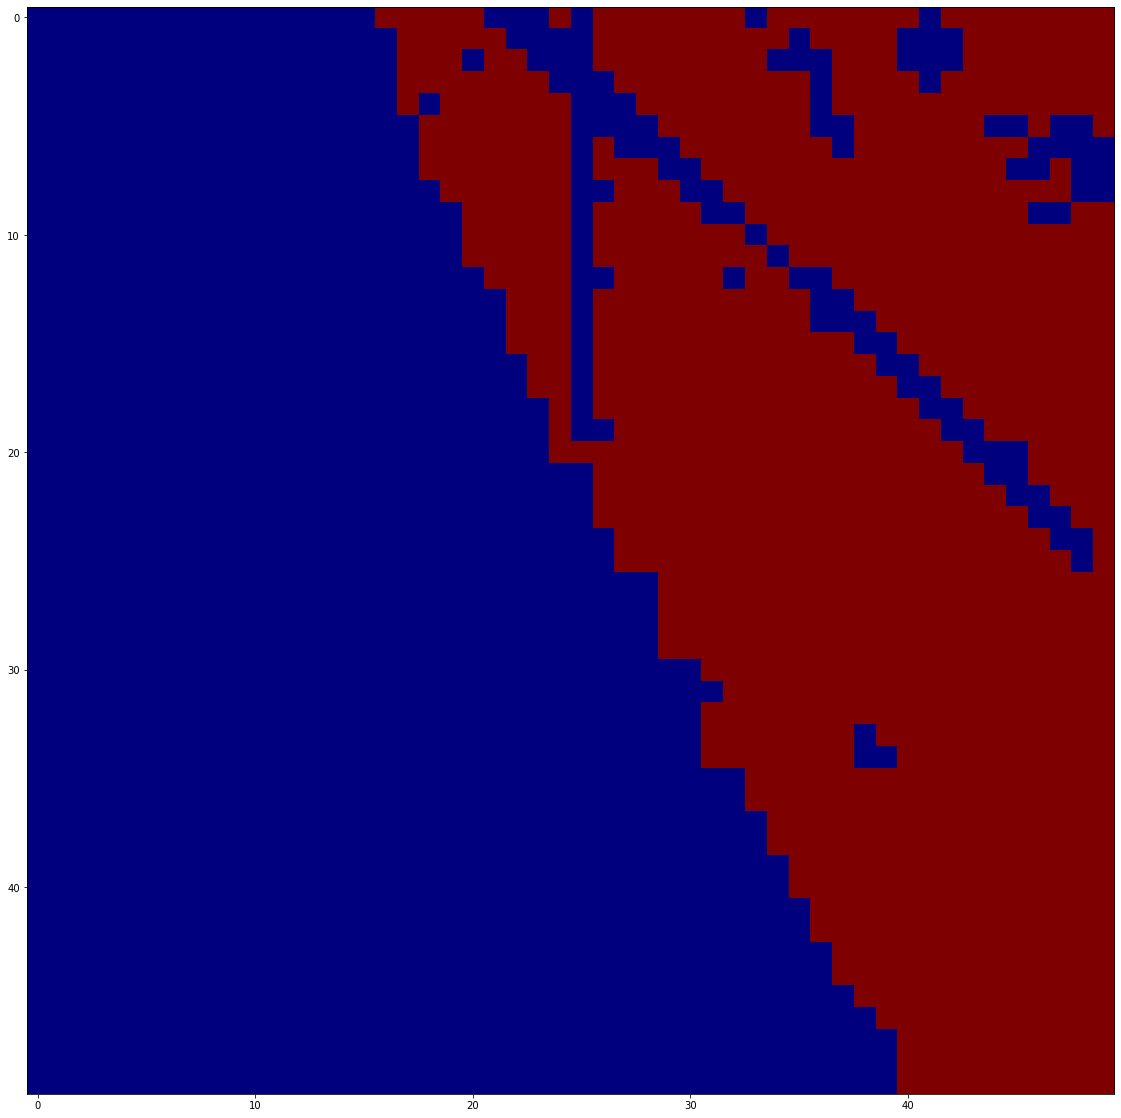

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(ClassTest,cmap='jet')

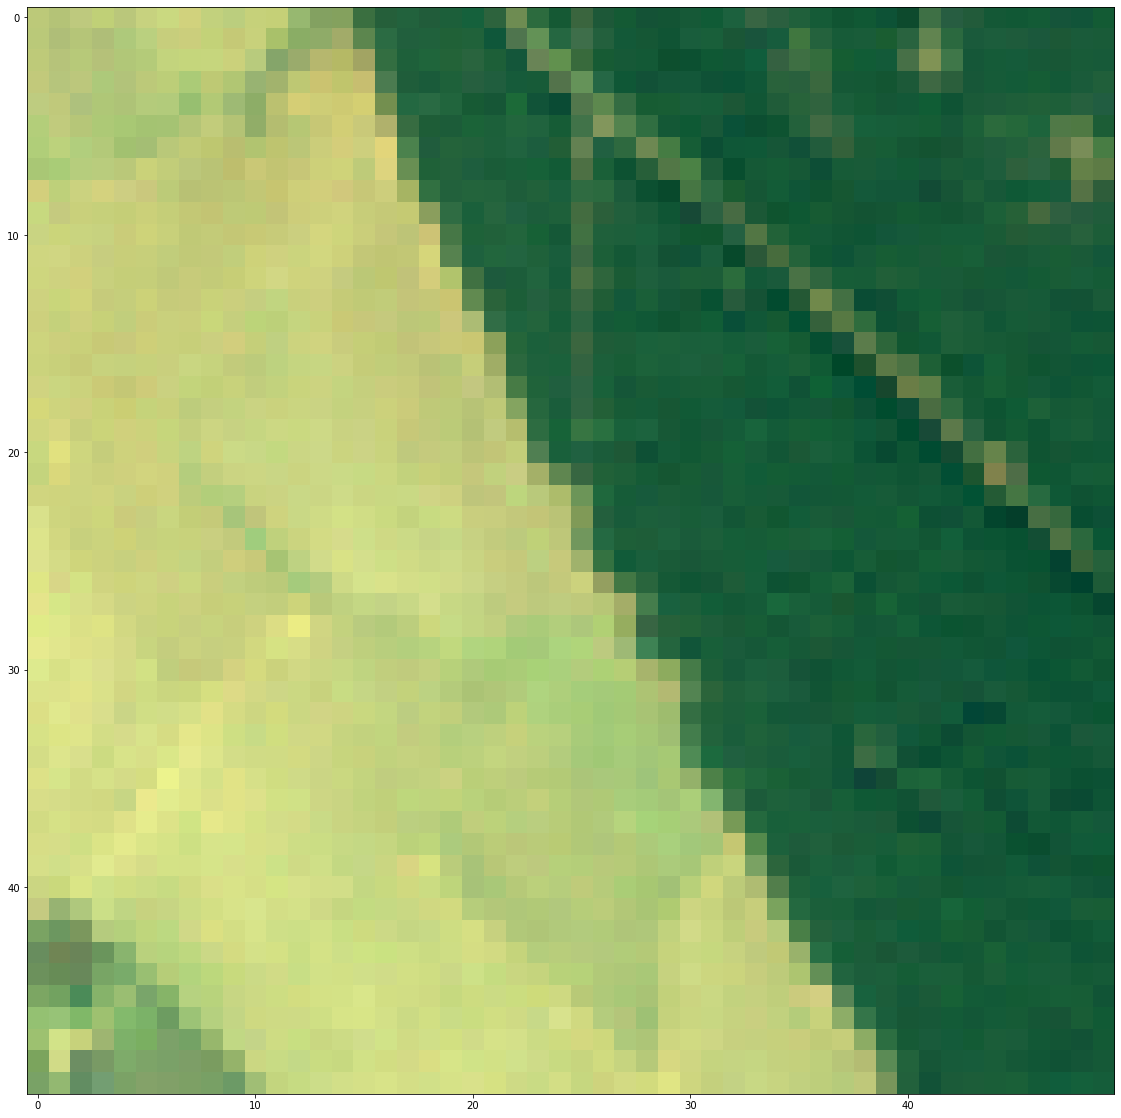

In [19]:
img_rescale = exposure.rescale_intensity(SubRGBTest, in_range=(p2, p98))
plt.figure(figsize=(20,20))
plt.imshow(img_as_ubyte(img_rescale))